In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [4]:
from nmt_run import *

In [5]:
cfg_path = "./sp2enw/sp_.50"

In [6]:
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

cnn_out_dim = rnn_in_units =  320


/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer
--------------------------------------------------------------------------------
model found = 
./sp2enw/sp_.50/seq2seq_130.model
finished loading ..
optimizer not found


In [7]:
log_train = np.loadtxt(os.path.join(cfg_path, "train.log"), delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(os.path.join(cfg_path, "dev.log"), delimiter=',', usecols = (0,1,2)).transpose()

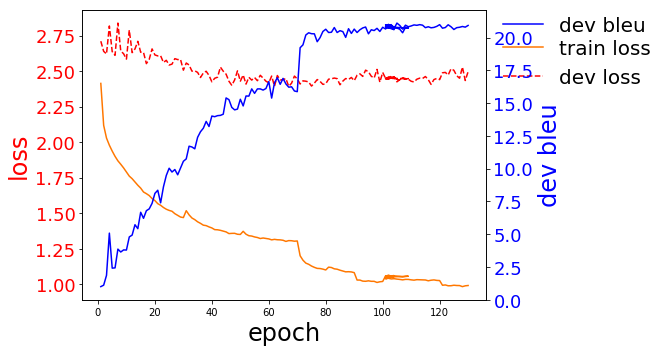

In [8]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [9]:
import nltk.translate.bleu_score

In [10]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [11]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, play_audio=False, displayN=-1):
    if displayN == -1:
        displayN = len(utts)
    es_ref = []
    en_ref = []
    en_ref2 = []
    en_ref3 = []
    en_ref4 = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))
            en_ref2.append(" ".join([w.decode() for w in m_dict[u]['en_w'][1]]))
            en_ref3.append(" ".join([w.decode() for w in m_dict[u]['en_w'][2]]))
            en_ref4.append(" ".join([w.decode() for w in m_dict[u]['en_w'][3]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    cnt = 0
    for u, es, en, en2, en3, en4, p in sorted(list(zip(utts, es_ref, en_ref, en_ref2, en_ref3, en_ref4, en_pred)))[:displayN]:
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        display_pp = PrettyTable(["cat","sent"], hrules=True)
        display_pp.align = "l"
        display_pp.header = False
        display_pp.add_row(["es ref", textwrap.fill(es,50)])
        display_pp.add_row(["en ref", textwrap.fill(en,50)])
        display_pp.add_row(["en ref2", textwrap.fill(en2,50)])
        display_pp.add_row(["en ref3", textwrap.fill(en3,50)])
        display_pp.add_row(["en ref4", textwrap.fill(en4,50)])
        
        
        display_pp.add_row(["en pred", textwrap.fill(p,50)])
        
        
        cnt += 1

        print(display_pp)
        if play_audio:
            play_utt(u, m_dict)
    

In [12]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        # for reference, 1st word is GO_ID, no need to display
        print("Utterance: {0:s}".format(u))
        print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))



In [13]:
m_cfg['model_dir']

'./sp2enw/sp_.50'

In [14]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, stemmify=False):
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
    for u in tqdm(utts, ncols=80):
        if type(m_dict[u][ref_key]) == list:
            if stemmify:
                en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
            else:
                en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_r_list = []
            for r in m_dict[u][ref_key]:
                if stemmify:
                    en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                else:
                    en_r_list.append(" ".join([w.decode() for w in r]))
            en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if stemmify:
            t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
        else:
            t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_hyp.append(t_str)

    out_fname = os.path.join(m_cfg['model_dir'], "{0:s}_mt-output".format(key))
    print("writing to file: {0:s}".format(out_fname))
    
    with open(out_fname, "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open(os.path.join(m_cfg['model_dir'], "{0:s}.ref0".format(key)), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open(os.path.join(m_cfg['model_dir'], "{0:s}_en.ref{1:d}".format(key,i)), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [15]:
train_key = m_cfg['train_set']
dev_key = m_cfg['dev_set']
batch_size=t_cfg['batch_size']
enc_key=m_cfg['enc_key']
dec_key=m_cfg['dec_key']
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
# -------------------------------------------------------------------------
# get data dictionaries
# -------------------------------------------------------------------------
map_dict, vocab_dict, bucket_dict = get_data_dicts(m_cfg)
batch_size = {'max': 256, 'med': 256, 'min': 256, 'scale': 1}

--------------------------------------------------
loading dict: ../chainer2/speech2text/both_fbank_out/map.dict


  0%|          | 0/3977 [00:00<?, ?it/s]

loading dict: ../chainer2/speech2text/both_fbank_out/train_vocab.dict
--------------------------------------------------
--------------------------------------------------
loading info_dict from=../chainer2/speech2text/both_fbank_out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp


 35%|███▍      | 48230/138708 [00:00<00:00, 482194.69it/s]

creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 491778.75it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
all done ...
loading dict: ../chainer2/speech2text/both_fbank_out/buckets_sp.dict
--------------------------------------------------
utterances in fisher_dev = 3979
utterances in fisher_dev2 = 3961
utterances in fisher_test = 3641
utterances in fisher_train = 138819
utterances in callhome_devtest = 3966
utterances in callhome_evltest = 1829
utterances in callhome_train = 15080
vocab size for sp = 0
vocab size for en_w = 17378


In [16]:
random.seed("meh")
# random.seed("haha")

In [ ]:
pred_sents, utts, dev_loss = feed_model(model,
                                        optimizer=optimizer,
                                        m_dict=map_dict[dev_key],
                                        b_dict=bucket_dict[dev_key],
                                        vocab_dict=vocab_dict,
                                        batch_size=batch_size,
                                        x_key=enc_key,
                                        y_key=dec_key,
                                        train=False,
                                        input_path=input_path,
                                        max_dec=m_cfg['max_en_pred'],
                                        t_cfg=t_cfg,
                                        use_y=False)

In [ ]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, m_cfg['max_en_pred']
min_len, max_len = 0, 1
displayN = 50
m_dict=map_dict[dev_key]
# wavs_path = os.path.join(m_cfg['data_path'], "wavs")
wavs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "wavs")
v_dict = vocab_dict['en_w']
key = m_cfg['dev_set']

In [ ]:
fsh_filt_pred, fsh_filt_utts = zip(*sorted([(p,u) for p, u in zip(pred_sents, utts) if (len(m_dict[u]['es_w']) >= min_len) and 
                                        (len(m_dict[u]['es_w']) <= max_len)]))

In [ ]:
print("length filtered utterances = {0:d}".format(len(fsh_filt_utts)))

In [ ]:
813 / 3977, (50+115+15+171) / 3977, (50+115+15+171) / 813

In [ ]:
display_words(m_dict, v_dict, 
              fsh_filt_pred, 
              fsh_filt_utts, dec_key, 
              key, 
              play_audio=True, 
              displayN=displayN)

In [ ]:
es_ref = []
en_ref = []
for u in fsh_filt_utts:
    es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
    if type(m_dict[u][dec_key]) == list:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
    else:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

en_pred = []
join_str = ' ' if dec_key.endswith('_w') else ''

In [ ]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text")

In [ ]:
b, chrf, h, r = calc_bleu(m_dict, 
                          v_dict, 
                          fsh_filt_pred, 
                          fsh_filt_utts, 
                          dec_key, 
                          ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

model_refs = {u: mr for u, mr in zip(fsh_filt_utts, r)}
model_hyps = {u: mh for u, mh in zip(fsh_filt_utts, h)}

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
                                           dec_key, key, stemmify=False)

In [ ]:
len(en_hyp)

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
model_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}

for utt_id, ref, hyp in zip(fsh_filt_utts, r, h):
    es_ref = [w.decode() for w in m_dict[utt_id]['es_w']]
    
    pval, rval = modified_precision_recall(ref, hyp, n=1)
    model_prec_recall['tc'] += pval.numerator
    model_prec_recall['tp'] += pval.denominator
    model_prec_recall['tr'] += rval.denominator

    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)
# end for
    
model_prec_recall['total_precision'] = model_prec_recall['tc'] / model_prec_recall['tp']
model_prec_recall['total_recall'] = model_prec_recall['tc'] / model_prec_recall['tr']

In [ ]:
print("\t\tModel metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      model_prec_recall['total_precision'],
                                                      "recall",
                                                      model_prec_recall['total_recall']))


In [ ]:
print("model-s2t BLEU score:")
"{0:0.3f}".format(100.0 * corpus_bleu(model_refs.values(), model_hyps.values()))

In [ ]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
_, _ = corpus_precision_recall(model_refs.values(), model_hyps.values())

In [ ]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
metrics = {"p": {1: [], 2: [], 3: [], 4: []},
           "r": {1: [], 2: [], 3: [], 4: []}}

for ix in range(len(list(model_refs.values())[0])):
    temp_refs = [[i[ix]] for i in model_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    ps, rs = corpus_precision_recall(temp_refs, model_hyps.values())
    for i, (p, r) in enumerate(zip(ps, rs)):
        metrics['p'][i+1].append(p)
        metrics['r'][i+1].append(r)
    

In [ ]:
def get_mean_std(vals_dict):
#     print("estimated mean")
    k = []
    u = []
    s = []
    for m, vals in vals_dict.items():
        k.append(m)
        u.append(np.mean(vals))
        s.append(np.std(vals)/np.sqrt(len(vals)))
        print("{0:10d}-gram = {1:.2f} ± {2:.2f}".format(m, np.mean(vals), np.std(vals)/np.sqrt(len(vals))))
        
    print(",".join(map(lambda x : "{0:.2f}".format(x), u)))
    print(",".join(map(lambda x : "{0:.2f}".format(x), s)))
    return k, u, s

In [ ]:
s2w_p_r = {}

print("Precision:")
_, s2w_p_r['p'], s2w_p_r['p_std'] = get_mean_std(metrics['p'])

print("Recall:")
_, s2w_p_r['r'], s2w_p_r['r_std'] = get_mean_std(metrics['r'])

In [ ]:
with open(os.path.join(m_cfg['model_dir'], "s2w_p_r.json"), "w") as out_f:
    json.dump(s2w_p_r, out_f, indent=4)

In [ ]:
model_predictions = {}
for u, hyp in zip(fsh_filt_utts, h):
    model_predictions[u] = hyp

### word level analysis

In [ ]:
top_k = 100
min_word_len = 1

In [ ]:
stop_words = set(nltk.corpus.stopwords.words("english"))
len(stop_words)

In [ ]:
def get_words(m_dict):
    words = []
    for u in m_dict:
        if type(m_dict[u]['en_w']) == list:
            words.extend([w.decode() for w in m_dict[u]['en_w']])
        else:
            for ref in m_dict[u]['en_w']:
                words.extend([w.decode() for w in ref])
    return Counter(words)

In [ ]:
# words in train
train_words = get_words(map_dict['fisher_train'])
train_words_top_k = [(w,f) for w, f in sorted(train_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

train_only_words = set(train_words.keys())

print("{0:20s} | {1:10d}".format("# train word types", len(train_words)))
print("{0:20s} | {1:10d}".format("# train word tokens", sum(train_words.values())))

In [ ]:
train_words_top_k[:5]

In [ ]:
[(w,f) for w,f in train_words_top_k if "'" in w]

In [ ]:
dev_words = get_words(map_dict['fisher_dev'])
dev_words_top_k = [(w,f) for w, f in sorted(dev_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

dev_only_words = set(dev_words.keys())

In [ ]:
dev_words_top_k[:5]

In [ ]:
oov_words = {w:f for w,f in dev_words.items() if w not in train_only_words}

In [ ]:
print("{0:20s} | {1:10d}".format("# dev word types", len(dev_only_words)))
print("{0:20s} | {1:10d}".format("# dev word tokens", sum(dev_words.values())))

print("{0:20s} | {1:10d}".format("# oov word types", len(oov_words)))
print("{0:20s} | {1:10d}".format("# oov word tokens", sum(oov_words.values())))


In [ ]:
"{0:.1f}%".format(sum(oov_words.values()) / sum(dev_words.values()) * 100)

Look at utterances which our model is doing better at, and compare to Google.

Are we doing better on a few calls only? Is there any particular speaker or call messing up our results?

### Query task

In [ ]:
crises_lex_fname = "../criseslex/CrisisLexLexicon/CrisisLexRec.txt"
train_text_fname= "../installs/fisher-callhome-corpus/corpus/ldc/fisher_train.en"
topics_fname = "../criseslex/fsp06_topics_in_english.txt"

In [ ]:
topics = [ "peace", "Music", "Marriage", "Religion", "Cell phones", 
           "Dating", "Telemarketing and SPAM", "Politics", "Travel", 
           "Technical devices", "Healthcare", "Advertisements", "Power", 
           "Occupations", "Movies", "Welfare", "Breaking up", "Location", 
           "Justice", "Memories", "Crime", "Violence against women", "Equality", 
            "Housing", "Immigration",     
            # new topics
           "Interracial", "Christians", "muslims", "jews", "e-mail", 
           "phone", "democracy", "Democratic", "Republican", "technology", 
           "leadership", "community", "jury", "police", "inequality", 
           "renting", "Violence", "immigrants", "immigrant", "skilled", 
           "Telemarketing", "SPAM", "skill", "job", "health", "mobile", 
            "ads", "physical", "emotional", "bubble", "rent", "economy", 
            "abuse", "women", "city", "country", "suburban", "dollar", 
            "united states", "laws", "phone", "race", "biracial", "interracial", 
            "marriage", "lyrics", "sexuality", "medicine", "television", "european",
            "home", "protect", "spouse", "language", "cellphone", "money",
            "doctor", "insurance", "cigarettes", "alcohol", "income", "salary",
            "class", "censor", "rating", "programs", "government",
            "relationship", "legal", "event", "life", "safe", "victim", "cops",
            "wage", "illegal"
            ]
topics = list(set(t.lower() for t in topics))
topics_stem = [stem(t) for t in topics]

In [ ]:
dev_words_stem = {}
for w in dev_words:
    stem_w = stem(w)
    if stem_w not in dev_words_stem:
        dev_words_stem[stem_w] = 0
    dev_words_stem[stem_w] += dev_words[w]
# end for

In [ ]:
len(topics)

In [ ]:
# NOTE this checks for # of occurrences of the word in the specified text
# We later use the # of utterrances, which will be lower or equal to this number
prune_topics = [t for t in topics if dev_words_stem.get(stem(t),0) > 10 and dev_words_stem.get(stem(t),0) < 100]
len(prune_topics)

In [ ]:
prune_topics[:5]

In [ ]:
random.seed("selec_query_terms")
sel_topics = random.sample(prune_topics, min(len(prune_topics), 100))

In [ ]:
len(sel_topics)

In [ ]:
def find_all_terms_references(utt_text, terms, text_key="en_w"):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u][text_key] if type(utt_text[u]) == dict 
             else utt_text[u])
        for r in l:
            for w in set(r):
                decoded_w = w.decode() if type(w) != str else w
                w_to_search = stem(decoded_w)
                if w_to_search in terms_set:
                    if w_to_search not in terms_search_res:
                        terms_search_res[w_to_search] = set()
                        full_words[w_to_search] = set()
                    terms_search_res[w_to_search].add(u)
                    full_words[w_to_search].add(decoded_w)
                # end if found
            # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, full_words


def find_all_terms_predictions(utt_text, terms):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        r = utt_text[u]
        for w in set(r):
            w_to_search = stem(w)
            if w_to_search in terms_set:
                if w_to_search not in terms_search_res:
                    terms_search_res[w_to_search] = set()
                    full_words[w_to_search] = set()
                terms_search_res[w_to_search].add(u)
                full_words[w_to_search].add(u)
                # end if found
            # end for current reference
    # end for all utterances
    return terms_search_res, full_words

In [ ]:
def terms_prec_recall(preds, refs):
    prec_recall = {}
    prec_recall = {'t':0, 'tp':0, 'tc':0, 'terms':{}}
    for term in refs.keys():
        prec_recall['terms'][term] = {}
        prec_recall['terms'][term]['t'] = len(refs[term])
        preds_occ = preds.get(term, set())
        prec_recall['terms'][term]['tp'] = len(preds_occ)
        prec_recall['terms'][term]['tc'] = len(refs[term] & preds_occ)
        prec_recall['t'] += prec_recall['terms'][term]['t']
        prec_recall['tp'] += prec_recall['terms'][term]['tp']
        prec_recall['tc'] += prec_recall['terms'][term]['tc']
    # end for each term
    return prec_recall

In [ ]:
ref_topics, ref_topic_labels = find_all_terms_references(map_dict['fisher_dev'], sel_topics)
pred_topics, pred_topics_topics_labels = find_all_terms_predictions(model_predictions, sel_topics)

In [ ]:
len(ref_topics), len(pred_topics)

In [ ]:
ref_topics

In [ ]:
prune_topics_in_utts = {k:v for k, v in ref_topics.items() if len(v) >=3}

In [ ]:
len(prune_topics_in_utts)

In [ ]:
from  matplotlib.ticker import FuncFormatter

In [ ]:
sns.set_style("darkgrid")

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6,10),nrows=1, ncols=1)


sorted_counts = [t[0] for t in sorted(ref_topics.items(), reverse=True, key=lambda t:len(t[1]))]
topic_count = [len(ref_topics[t]) for t in sorted_counts]

topic_labels = ["-".join(list(ref_topic_labels[t])[:3]) for t in sorted_counts]

ax = sns.barplot(x=topic_count, 
                 y=topic_labels, 
                 color=tableau20[6], alpha=.7)
                 #**{"label":"topic counts", "alpha":0.5}, ax=ax)

# ax.set_xlabel("# of utts in which topic occurs", size=20)

max_count_val = max([len(v) for v in ref_topics.values()])
min_count_val = max([len(v) for v in ref_topics.values()])
plt.xticks(list(range(0,max_count_val, 5))+[min_count_val, max_count_val])

# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9),
#                       ncol=1, fancybox=True, shadow=True, fontsize=20)

sns.despine(left=True, bottom=True, top=True, right=False)

for t in ax.get_yticklabels():
    t.set_fontsize(15) 
    
for i, t in enumerate(ax.get_xticklabels()):
    if i > 0 and i < (len(ax.get_xticklabels())-1):
        t.set_visible(False)
    else:
        t.set_fontsize(16)

fig.tight_layout()


fig.savefig("../criseslex/sel_topics_new.png", dpi=300)

In [ ]:
model_topics_p_r = terms_prec_recall(preds = pred_topics, refs = ref_topics)

In [ ]:
model_topics_p_r['precision'] = model_topics_p_r['tc'] / model_topics_p_r['tp']
model_topics_p_r['recall'] = model_topics_p_r['tc'] / model_topics_p_r['t']

In [ ]:
print("-"*40)
print("-------------- Query by Text")
print("-"*40)
print("{0:20s} | {1:5.2f}%".format("precision", model_topics_p_r['precision']*100.0))
print("{0:20s} | {1:5.2f}%".format("recall", model_topics_p_r['recall']*100.0))

In [ ]:
with open(os.path.join(m_cfg['model_dir'], "topics_p_r.json"), "w") as out_f:
    json.dump(model_topics_p_r, out_f, indent=4)

In [106]:
def find_all_terms_es_references(utt_text, term):
    terms_search_res = set()
    total_word_count = 0

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u]["es_w"] if type(utt_text[u]) == dict 
             else utt_text[u])
        #if len(l) == 1 and l[0].decode() == term:
        if set(l) == set(term.split()):
            terms_search_res.add(u)
            total_word_count += 1
            # end if found
        # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, total_word_count


In [129]:
set_key = "fisher_train"

In [130]:
hmm, tot_count = find_all_terms_es_references(map_dict[set_key], b'claro')

100%|███████████████████████████████| 138819/138819 [00:00<00:00, 274676.89it/s]


In [131]:
len(hmm)

1715

In [132]:
all_ref_words = {}
all_match_count = 0
no_match_count = 0

utt_refs_set = {}
for utt in hmm:
    #print("-"*60)
    #print(utt)
    curr_ref = {k : "" for k in range(4)}
    if "train" in set_key:
        r = map_dict[set_key][utt]["en_w"]
        en_ref_words = " ".join(w.decode() for w in r)
        curr_ref[0] = en_ref_words
        if en_ref_words not in all_ref_words:
            all_ref_words[en_ref_words] = 0
        all_ref_words[en_ref_words] += 1
    else:
        for i, r in enumerate(map_dict[set_key][utt]["en_w"]):
            en_ref_words = " ".join(w.decode() for w in r)
            curr_ref[i] = en_ref_words
            #print(" ".join(w.decode() for w in r), end="----")
            if en_ref_words not in all_ref_words:
                all_ref_words[en_ref_words] = 0
            all_ref_words[en_ref_words] += 1
    #print(curr_ref.values())

    
    utt_refs_set[utt] = set(curr_ref.values())
        

In [113]:
len(utt_refs_set['20051023_232057_325_fsp-B-77']) if "dev" in set_key else 0

0

In [114]:
 if "dev" in set_key:
    start_set = utt_refs_set['20051023_232057_325_fsp-B-77']
    for utt in utt_refs_set:
        start_set = start_set & utt_refs_set[utt]

In [102]:
start_set

NameError: name 'start_set' is not defined

In [ ]:
start_set

In [133]:
all_match_count = sum([len(utt_refs_set[utt]) == 1 for utt in utt_refs_set])
all_dont_match_count = sum([len(utt_refs_set[utt]) == 4  for utt in utt_refs_set])

In [134]:
all_match_count, all_dont_match_count

(0, 0)

In [135]:
all_ref_words, len(all_ref_words)

({'clear': 1,
  'clearly': 51,
  'clearly clearly': 3,
  'clearly clearly clearly': 2,
  'none': 1,
  'of': 1,
  'of course': 199,
  'of course of course': 19,
  'of course of course of course': 1,
  'of course of course of course of course': 1,
  'of couse': 2,
  'right': 61,
  'right right': 2,
  'sure': 1181,
  'sure of course': 1,
  'sure sue': 1,
  'sure sure': 159,
  'sure sure of course': 1,
  'sure sure sure': 22,
  'sure sure sure sure': 2,
  'sure sure sure sure sure': 1,
  'sure ure sure': 1,
  'yes': 2},
 23)

In [200]:
tot_count

1715

In [137]:
utt_refs_set

{'20051211_184252_723_fsp-A-17': {'', 'sure'},
 '20060110_200611_998_fsp-B-90': {'', 'right'},
 '20051109_232505_454_fsp-B-9': {'', 'of course'},
 '20060116_212845_1063_fsp-B-107': {'', 'of course'},
 '20051115_182149_515_fsp-B-41': {'', 'of course'},
 '20051215_190419_758_fsp-B-69': {'', 'sure'},
 '20060103_211732_926_fsp-A-12': {'', 'sure'},
 '20051122_190326_576_fsp-A-41': {'', 'of course of course'},
 '20051103_163507_398_fsp-B-43': {'', 'sure'},
 '20060104_181040_929_fsp-A-54': {'', 'sure'},
 '20060114_191056_1043_fsp-A-39': {'', 'sure'},
 '20051021_222225_307_fsp-B-109': {'', 'sure'},
 '20051222_181506_846_fsp-A-32': {'', 'sure'},
 '20051123_211514_585_fsp-A-91': {'', 'sure'},
 '20051027_231329_354_fsp-A-60': {'', 'of course'},
 '20051129_190152_615_fsp-A-46': {'', 'sure sure'},
 '20060104_181040_929_fsp-A-45': {'', 'of course of course'},
 '20051121_190155_571_fsp-B-64': {'', 'sure'},
 '20050917_210805_75_fsp-B-85': {'', 'sure'},
 '20051112_165916_483_fsp-A-101': {'', 'sure'},
 

In [138]:
m_dict = map_dict[set_key]

In [139]:
input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])

In [154]:
sel_utts = [utt for utt in utt_refs_set]

In [257]:
batch_data = get_batch(m_dict, enc_key, dec_key, sel_utts[:101], vocab_dict, 200, 10, input_path=input_path)

ERROR!! file not found: ../chainer2/speech2text/both_fbank_out/fisher_train/20051021/20051021_222225_307_fsp-B-109.npy


In [258]:
batch_data['X'].shape

(100, 200, 40)

In [259]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [260]:
A = xp.asnumpy(batch_data['X'].data)

In [261]:
type(A)

numpy.ndarray

In [262]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path = fastdtw(A[1], A[2], dist=euclidean)
print(distance)

951.6700701043387


In [263]:
dtw_out = np.zeros((len(A), len(A)))

In [264]:
for i in tqdm(range(len(A))):
    for j in range(i,len(A)):
        dtw_out[i,j], _ = fastdtw(A[i], A[j], dist=euclidean)

100%|██████████| 100/100 [10:43<00:00,  6.44s/it]


In [249]:
dtw_out

array([[ 0.,  1.,  1., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]])

In [239]:
np.mean(dtw_out), np.std(dtw_out)

(935.0290316619654, 504.49319019667695)

In [242]:
dtw_out[dtw_out < 1000] = 0

In [245]:
dtw_out[dtw_out > 1] = 1

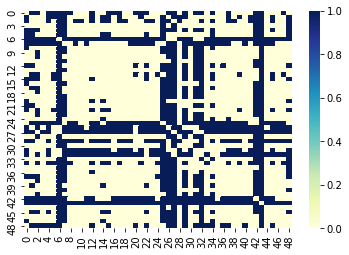

In [247]:
sns.heatmap(dtw_out, cmap="YlGnBu")

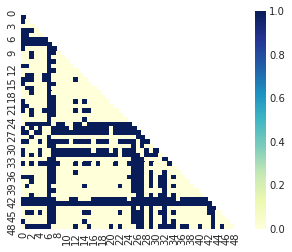

In [248]:
mask = np.zeros_like(dtw_out)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dtw_out, mask=mask, square=True, cmap="YlGnBu")

In [210]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [225]:
X = dtw_out

In [226]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering

In [227]:
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Elapsed time: 0.00s
Number of points: 49


Compute structured hierarchical clustering...
Elapsed time: 0.01s
Number of points: 49


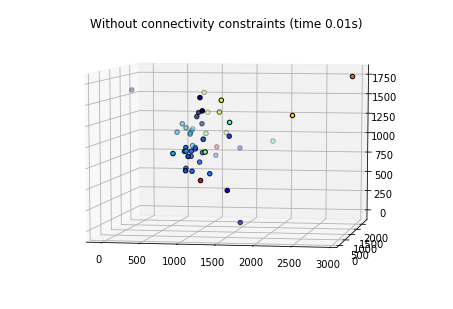

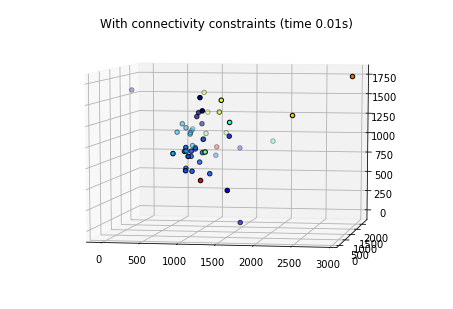

In [231]:
# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=25, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=10, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

In [250]:
n_clusters

NameError: name 'n_clusters' is not defined

NameError: name 'n_clusters' is not defined

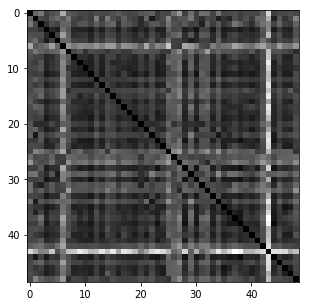

In [233]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(X, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l, contours=1,
                colors=[plt.cm.spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

In [189]:
similarities = cosine_similarity(A)
print('pairwise dense output:\n {}\n'.format(similarities))

ValueError: Found array with dim 3. check_pairwise_arrays expected <= 2.

In [142]:
"20051021_222225_307_fsp-B-109" in map_dict['fisher_train']

True

In [143]:
def get_batch(m_dict, x_key, y_key, utt_list, vocab_dict,
              max_enc, max_dec, input_path=''):
    batch_data = {'X':[], 'y':[]}
    # -------------------------------------------------------------------------
    # loop through each utterance in utt list
    # -------------------------------------------------------------------------
    for u in utt_list:
        # ---------------------------------------------------------------------
        #  add X data
        # ---------------------------------------------------------------------
        if x_key == 'sp':
            # -----------------------------------------------------------------
            # for speech data
            # -----------------------------------------------------------------
            # get path to speech file
            utt_sp_path = os.path.join(input_path, "{0:s}.npy".format(u))
            if not os.path.exists(utt_sp_path):
                # for training data, there are sub-folders
                utt_sp_path = os.path.join(input_path,
                                           u.split('_',1)[0],
                                           "{0:s}.npy".format(u))
            if os.path.exists(utt_sp_path):
                x_data = xp.load(utt_sp_path)
                # truncate max length
                batch_data['X'].append(x_data[:max_enc])
            else:
                # -------------------------------------------------------------
                # exception if file not found
                # -------------------------------------------------------------
                print("ERROR!! file not found: {0:s}".format(utt_sp_path))
                # -------------------------------------------------------------
        else:
            # -----------------------------------------------------------------
            # for text data
            # -----------------------------------------------------------------
            x_ids = [vocab_dict[x_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][x_key]]
            x_ids = xp.asarray(x_ids, dtype=xp.int32)
            batch_data['X'].append(x_ids[:max_enc])
            # -----------------------------------------------------------------
        # ---------------------------------------------------------------------
        #  add labels
        # ---------------------------------------------------------------------
        if type(m_dict[u][y_key]) == list:
            en_ids = [vocab_dict[y_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][y_key]]
        else:
            # dev and test data have multiple translations
            # choose the first one for computing perplexity
            en_ids = [vocab_dict[y_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][y_key][0]]
        y_ids = [GO_ID] + en_ids[:max_dec-2] + [EOS_ID]
        batch_data['y'].append(xp.asarray(y_ids, dtype=xp.int32))
        # ---------------------------------------------------------------------
    # -------------------------------------------------------------------------
    # end for all utterances in batch
    # -------------------------------------------------------------------------
    if len(batch_data['X']) > 0 and len(batch_data['y']) > 0:
        batch_data['X'] = F.pad_sequence(batch_data['X'], padding=PAD_ID)
        batch_data['y'] = F.pad_sequence(batch_data['y'], padding=PAD_ID)
    return batch_data